In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

  Using cached finance_datareader-0.9.96-py3-none-any.whl.metadata (12 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached lxml-6.0.0-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
  Using cached plotly-6.2.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached requests_file-2.1.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
  Using cached narwhals-1.48.0-py3-none-any.whl.metadata (11 kB)
Using cached finance_datareader-0.9.96-py3-none-any.whl (48 kB)
Using cached beautifulsoup4-4.13.4-py3-none-any.whl (187 kB)
Using cached soupsieve-2.7-py3-none-any.whl (36 kB)
Using cached lxml-6.0.0-cp311-cp311-win_amd64.whl (4.0 MB)
Using cached plotly-6.2.0-py3-none-any.whl (9.6 MB)
Using cached narwhals-1.48.0-py3-none-any.whl (376 kB)
Using cached requests_file-2.1.0-py2.py3-none-any.whl (4.2 kB)

   ----- ---------------------------------- 1/7 [narwhals]
   ----- ---------------------------------- 1/7 [na

In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [27]:
df = fdr.DataReader('052400', '2024-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-07-17,55900,56400,54100,55000,154265,-0.005425
2025-07-18,55100,61600,53800,61000,946798,0.109091
2025-07-21,64300,64700,58600,60800,403640,-0.003279
2025-07-22,59800,60000,56400,57000,237880,-0.062500
2025-07-23,55700,56800,54600,56100,143470,-0.015789


# 분석 코드

In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

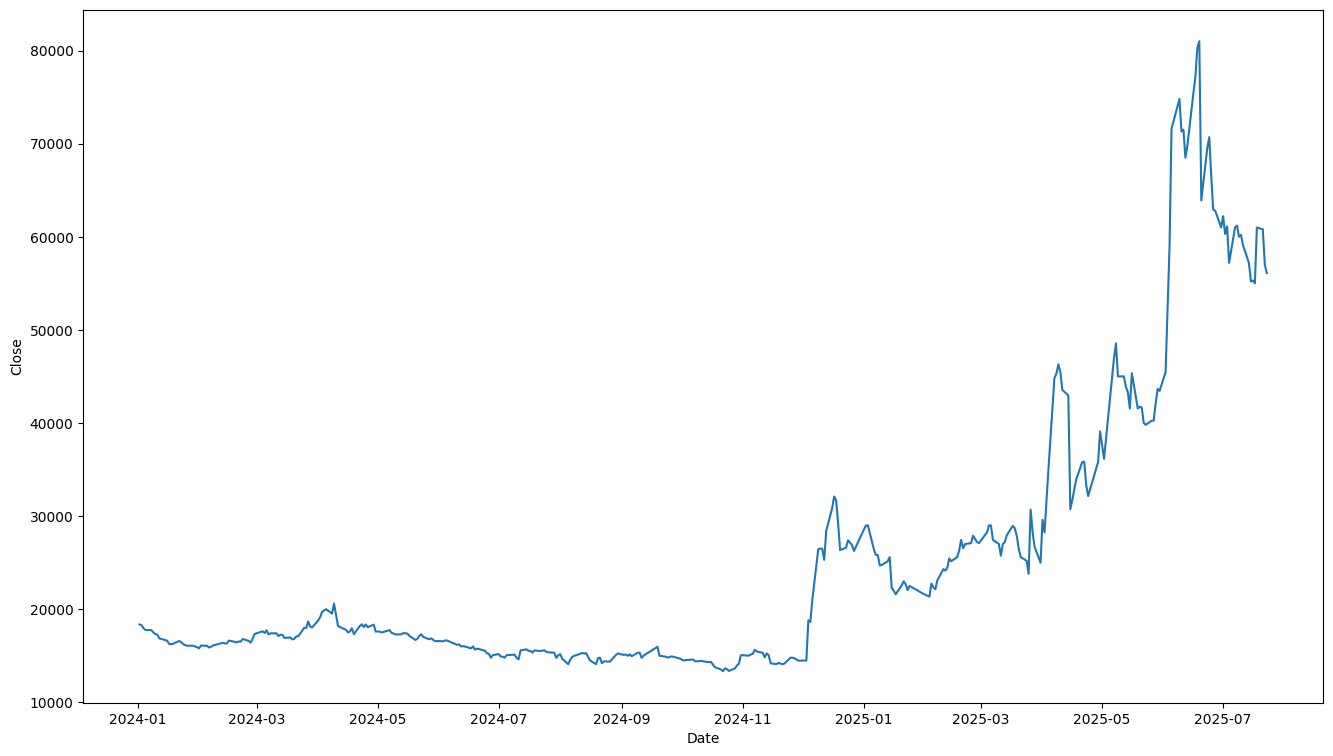

In [91]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [122]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

features = ['Open','High','Low','Volume']
X_all = x_scaler.fit_transform(df[features])
y_all = y_scaler.fit_transform(df[['Close']]).flatten()

In [123]:
#넘파이 배열로 변경
x = X_all.astype(np.float32)
y = y_all.astype(np.float32)

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [124]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([174, 5, 4]) torch.Size([174, 1])


In [125]:
x_train_seq

tensor([[[0.0669, 0.0665, 0.0880, 0.0038],
         [0.0720, 0.0680, 0.0929, 0.0040],
         [0.0711, 0.0634, 0.0897, 0.0031],
         [0.0657, 0.0605, 0.0818, 0.0088],
         [0.0673, 0.0593, 0.0850, 0.0021]],

        [[0.0720, 0.0680, 0.0929, 0.0040],
         [0.0711, 0.0634, 0.0897, 0.0031],
         [0.0657, 0.0605, 0.0818, 0.0088],
         [0.0673, 0.0593, 0.0850, 0.0021],
         [0.0666, 0.0586, 0.0817, 0.0033]],

        [[0.0711, 0.0634, 0.0897, 0.0031],
         [0.0657, 0.0605, 0.0818, 0.0088],
         [0.0673, 0.0593, 0.0850, 0.0021],
         [0.0666, 0.0586, 0.0817, 0.0033],
         [0.0610, 0.0533, 0.0759, 0.0027]],

        ...,

        [[0.0063, 0.0000, 0.0186, 0.0015],
         [0.0033, 0.0000, 0.0185, 0.0019],
         [0.0000, 0.0006, 0.0182, 0.0001],
         [0.0063, 0.0075, 0.0227, 0.0024],
         [0.0100, 0.0076, 0.0273, 0.0016]],

        [[0.0033, 0.0000, 0.0185, 0.0019],
         [0.0000, 0.0006, 0.0182, 0.0001],
         [0.0063, 0.0075, 0.0227

In [126]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

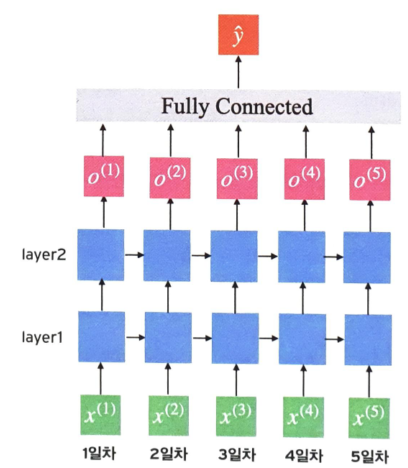

In [127]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [128]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out, _    = self.rnn(x, h0)
    # 마지막 타임스텝(hidden)만 사용
    out_last  = out[:, -1, :]    # (batch, hidden_size)
    y_pred    = self.fc(out_last)
    return y_pred

In [129]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [130]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [131]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0678
[epoch : 10] loss: 0.0003
[epoch : 20] loss: 0.0002
[epoch : 30] loss: 0.0002
[epoch : 40] loss: 0.0001


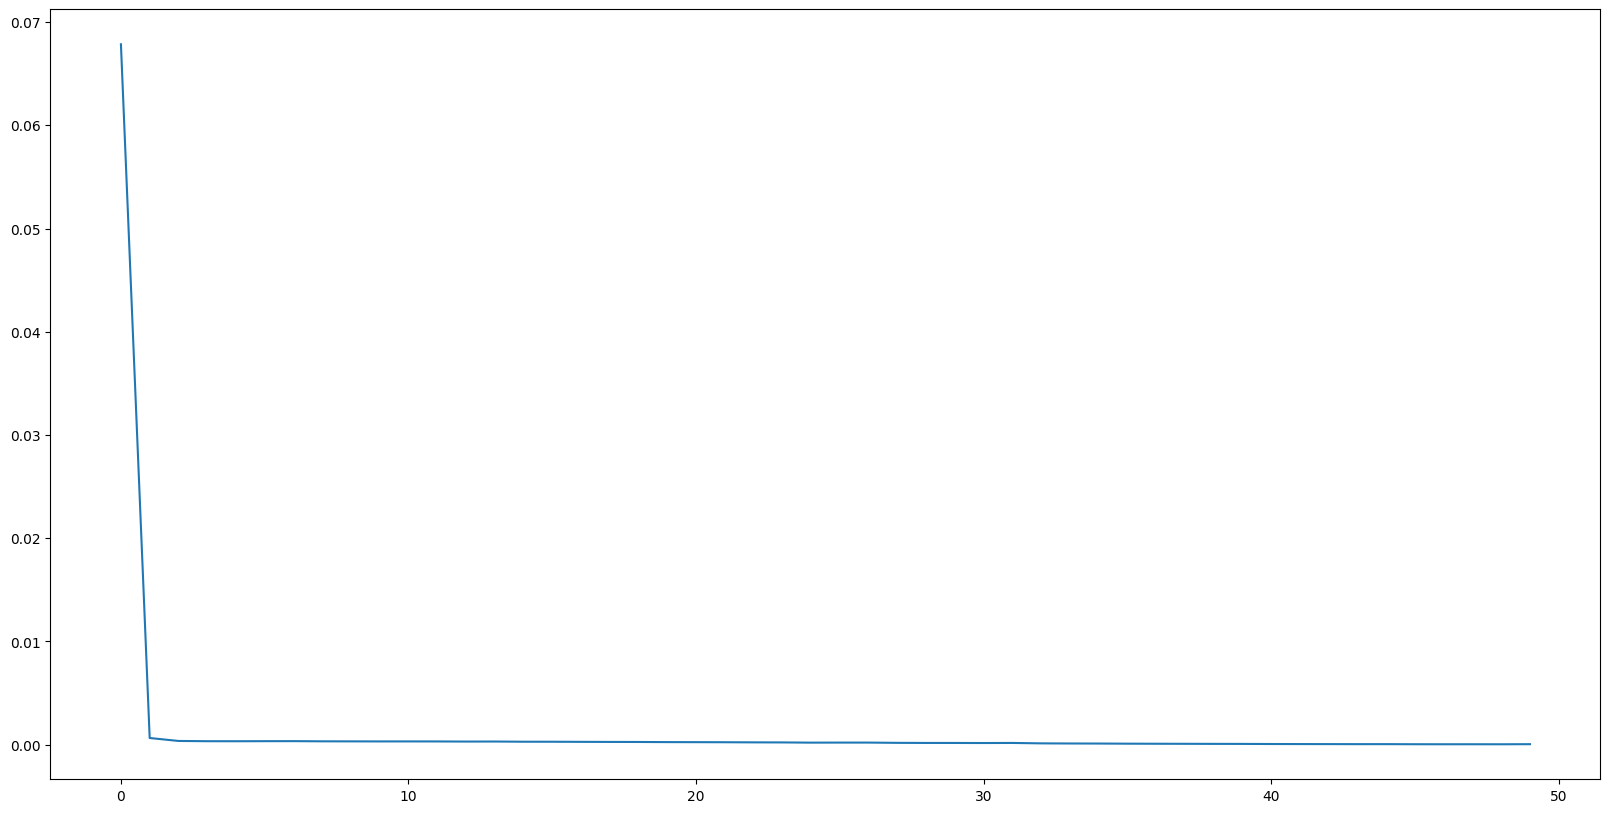

In [132]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [133]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

In [134]:
pred_price = y_scaler.inverse_transform(
                np.array(pred).reshape(-1, 1)
             )
actual_price = y_scaler.inverse_transform(
                  y_seq.cpu().numpy()
               ) 

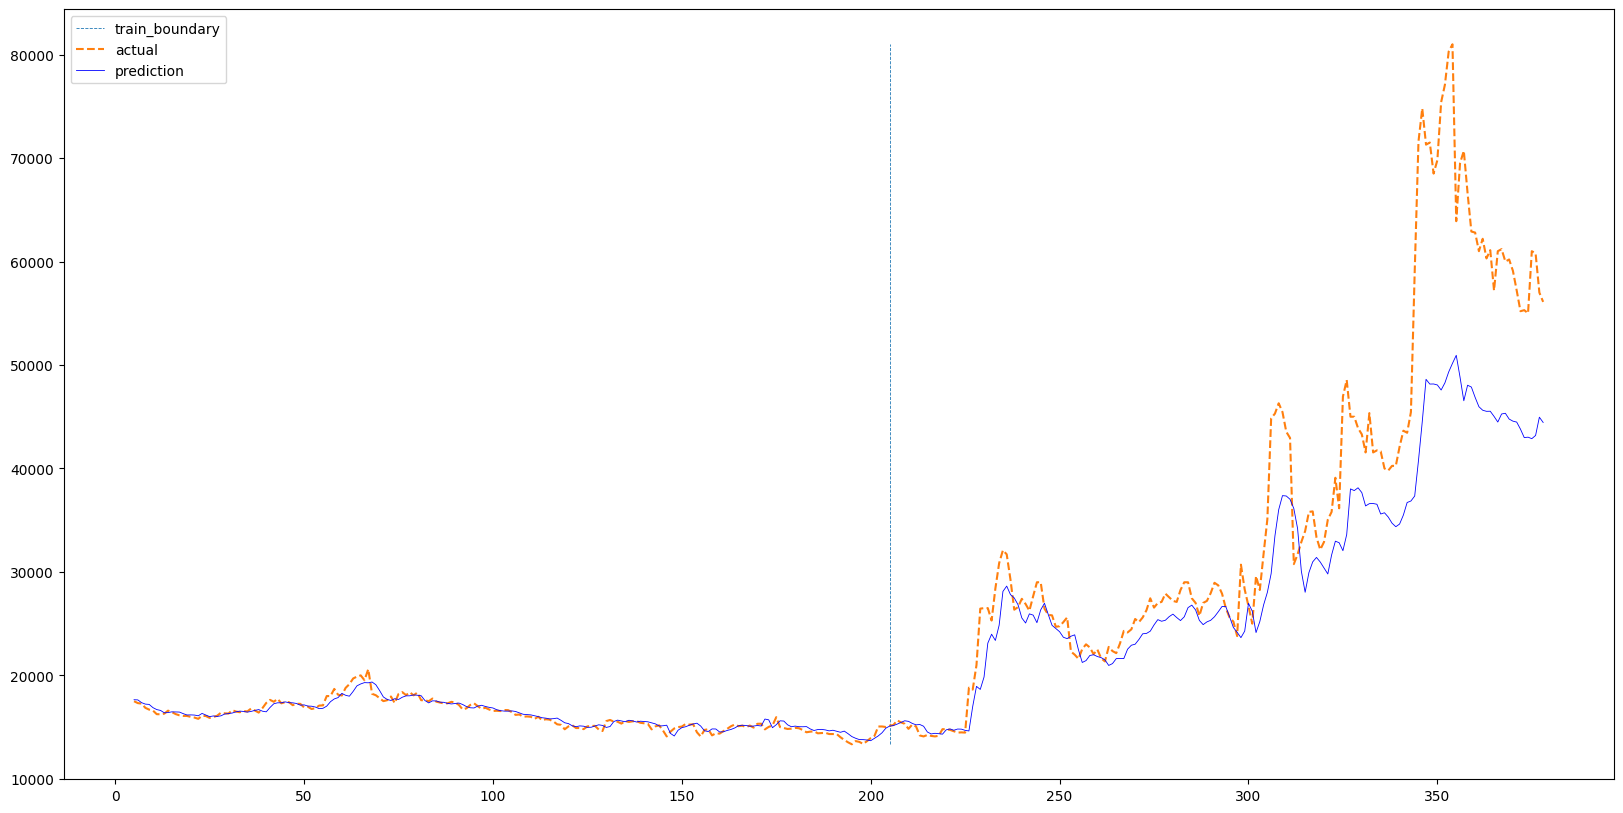

In [135]:
plt.figure(figsize=(20, 10))
total_len  = sequence_length + len(pred_price)
x_index    = np.arange(sequence_length, total_len)
plt.plot(np.ones(100) * (sequence_length + split),
         np.linspace(actual_price.min(), actual_price.max(), 100),
         '--', linewidth=0.6)
plt.plot(x_index, actual_price, '--')           # 실제
plt.plot(x_index, pred_price,  'b', linewidth=0.6)  # 예측
plt.legend(['train_boundary', 'actual', 'prediction'])
plt.show()

# LSTM
## 모델구축

In [136]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [137]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [138]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [139]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [140]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0057
[epoch: 10] loss: 0.0003
[epoch: 20] loss: 0.0001
[epoch: 30] loss: 0.0001
[epoch: 40] loss: 0.0001


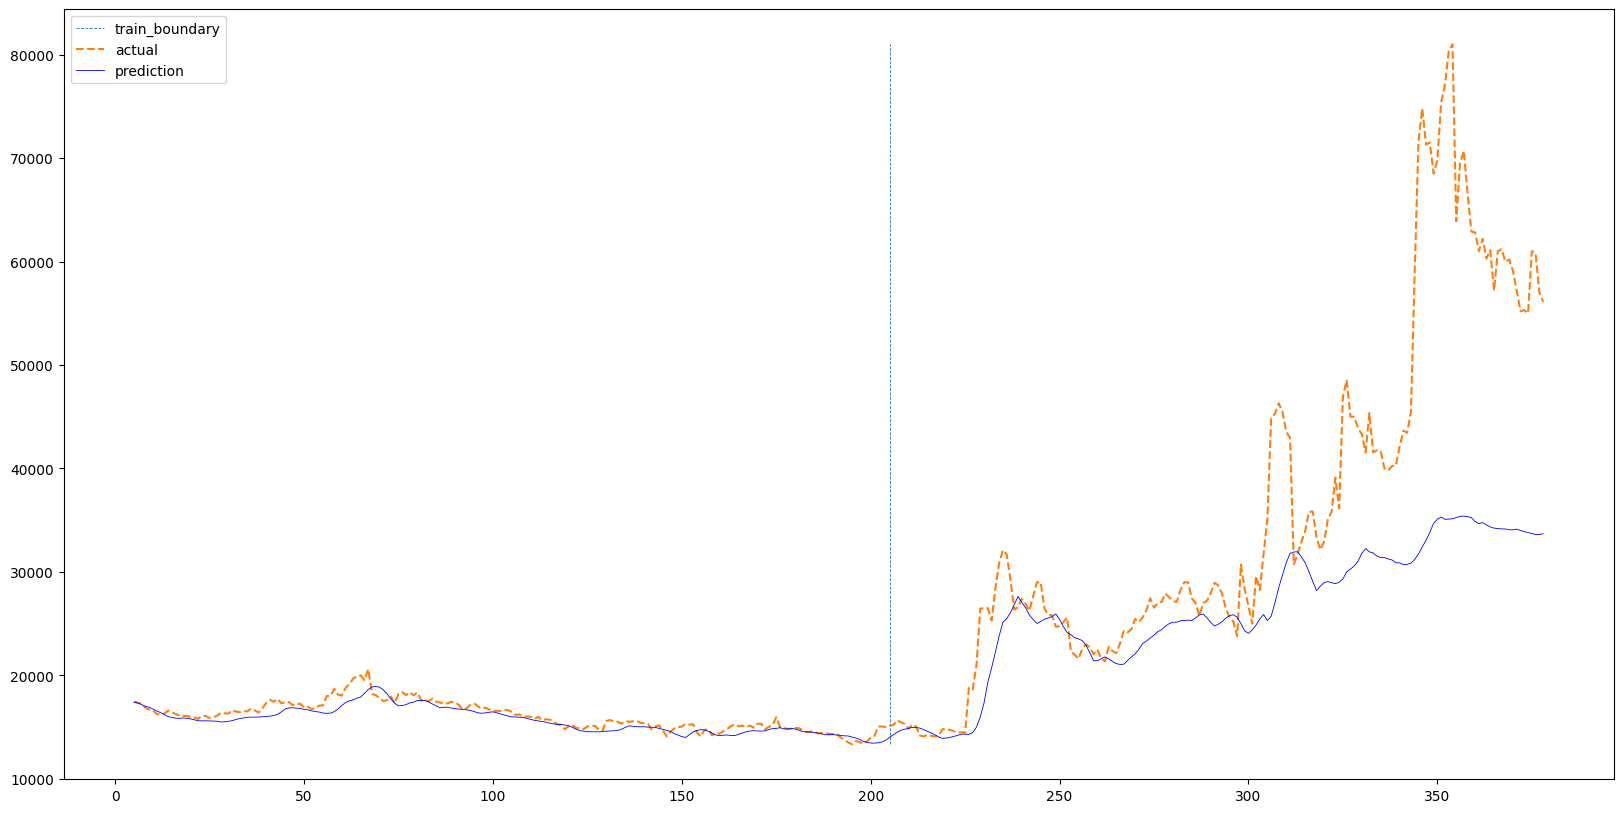

In [142]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

pred_price = y_scaler.inverse_transform(
                np.array(pred).reshape(-1, 1)
             )
actual_price = y_scaler.inverse_transform(
                  y_seq.cpu().numpy()
               ) 

plt.figure(figsize=(20, 10))
total_len  = sequence_length + len(pred_price)
x_index    = np.arange(sequence_length, total_len)
plt.plot(np.ones(100) * (sequence_length + split),
         np.linspace(actual_price.min(), actual_price.max(), 100),
         '--', linewidth=0.6)
plt.plot(x_index, actual_price, '--')           # 실제
plt.plot(x_index, pred_price,  'b', linewidth=0.6)  # 예측
plt.legend(['train_boundary', 'actual', 'prediction'])
plt.show()